In [1]:
import numpy as np
import matplotlib.pyplot as plt

from adabmDCA.dataset import DatasetDCA
from adabmDCA.utils import init_chains
from adabmDCA.fasta import get_tokens
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
path_log_old = "/home/lorenzo/Documents/models/proteorhodopsin/old_sampling.log"
path_log_new = "/home/lorenzo/Documents/models/proteorhodopsin/new_sampling.log"
path_log_new_metropolis = "/home/lorenzo/Documents/models/proteorhodopsin/new_sampling_metropolis.log"

def get_logs(fname: str):
    with open(fname, "r") as f:
        start_collecting = False
        logs = {}
        for line in f:
            if line.startswith("Epochs"):
                keys = line.strip().split()
                logs = {key: [] for key in keys}
                start_collecting = True
                continue
            if start_collecting:
                values = line.strip().split()
                for key, value in zip(keys, values):
                    logs[key].append(float(value))
    return logs

In [18]:
logs_old = get_logs(path_log_old)
logs_new = get_logs(path_log_new)
logs_new_metropolis = get_logs(path_log_new_metropolis)

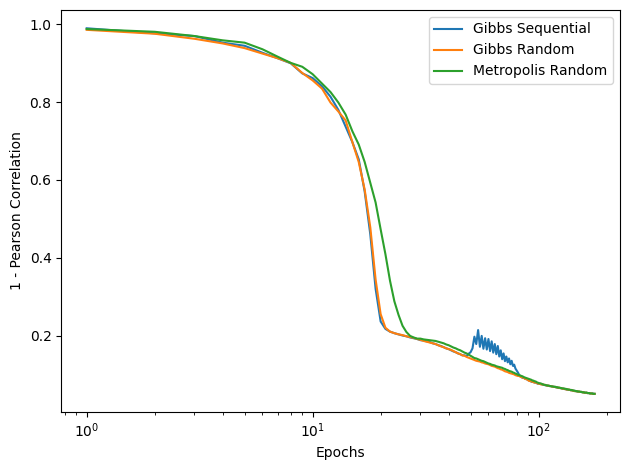

In [23]:
fig = plt.figure(dpi=100)
plt.plot(logs_old["Epochs"], 1 - np.array(logs_old["Pearson"]), label="Gibbs Sequential")
plt.plot(logs_new["Epochs"], 1 - np.array(logs_new["Pearson"]), label="Gibbs Random")
plt.plot(logs_new_metropolis["Epochs"], 1 - np.array(logs_new_metropolis["Pearson"]), label="Metropolis Random")
plt.xlabel("Epochs")
plt.ylabel("1 - Pearson Correlation")
plt.xscale("log")
plt.legend()
plt.tight_layout()

In [49]:
msid, stdsid = get_seqid(chains[1], chains[29:56])
print(f"Mean sequence identity: {msid.item():.4f} ± {stdsid.item():.4f}")

Mean sequence identity: 5.4444 ± 0.4347


## Contact maps

In [2]:
from adabmDCA.fasta import get_tokens
from adabmDCA.io import load_params
from adabmDCA.dca import get_contact_map, get_mf_contact_map
from adabmDCA.fasta import import_from_fasta
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_params = "/home/lorenzo/Documents/models/PF00072/bmDCA_lr0.01_params.dat"
path_data = "/home/lorenzo/Documents/data/PF00072/PF00072.fasta"

tokens = get_tokens("protein")
params = load_params(path_params, tokens, device=torch.device("cpu"))

_, data = import_from_fasta(
    fasta_name=path_data,
    tokens=tokens,
    filter_sequences=True
)
data_oh = torch.tensor(np.eye(21)[data], device=device)

In [3]:
cm_bmdca = get_contact_map(params=params, tokens=tokens)
cm_mfdca = get_mf_contact_map(data=data_oh, tokens=tokens)

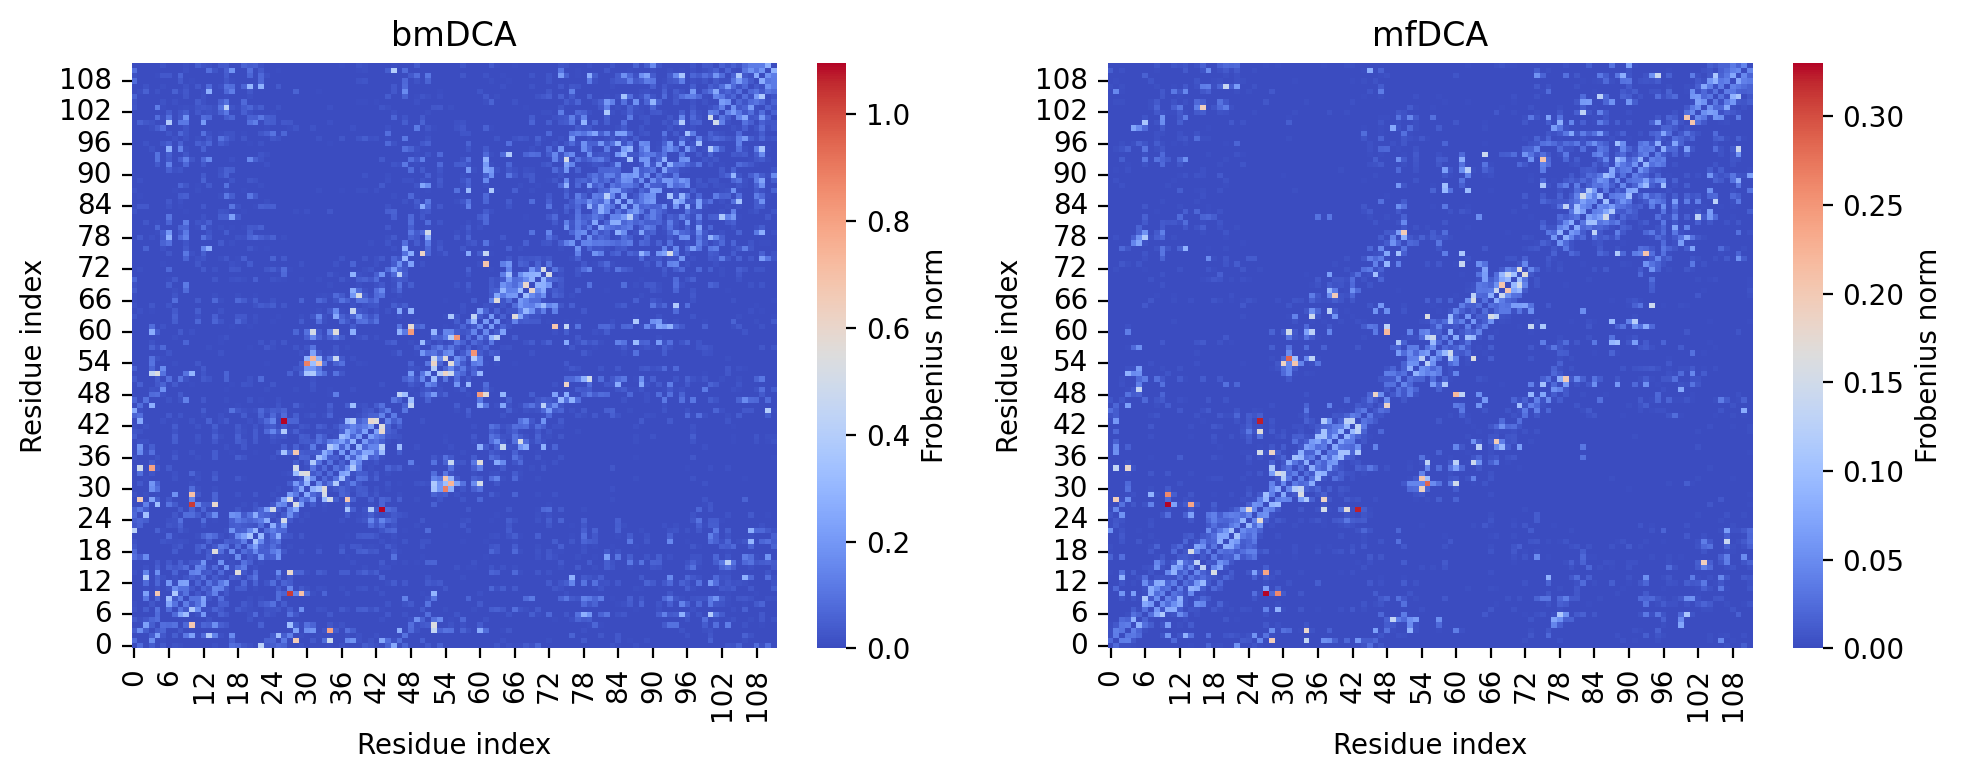

In [5]:
import matplotlib.pyplot as plt
from adabmDCA.plot import plot_contact_map

threshold = 0.0

cm_plot_bmdca = cm_bmdca.copy()
cm_plot_bmdca[cm_plot_bmdca < threshold] = 0
cm_plot_mfdca = cm_mfdca.copy()
cm_plot_mfdca[cm_plot_mfdca < threshold] = 0

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(10, 4))
ax[0] = plot_contact_map(cm=cm_plot_bmdca, ax=ax[0], title="bmDCA")
ax[0].set_title("bmDCA")
ax[1] = plot_contact_map(cm=cm_plot_mfdca, ax=ax[1], title="mfDCA")
ax[1].set_title("mfDCA")
fig.tight_layout()

In [ ]:
import numpy as np
import torch
from typing import Tuple, Dict
from adabmDCA.stats import get_covariance_matrix

def get_mf_contact_map(
    data: torch.Tensor,
    tokens: str,
    weights: torch.Tensor | None = None
) -> np.ndarray:
    """
    Computes the contact map from the model coupling matrix.

    Args:
        params (Dict[str, torch.Tensor]): Model parameters.
        tokens (str): Alphabet.
        weights (torch.Tensor | None): Weights for the data points. Defaults to None.

    Returns:
        np.ndarray: Contact map.
    """
    device = data.device
    dtype = data.dtype
    L, q = data.shape[1], data.shape[2]
    # Get index of the gap symbol
    gap_idx = tokens.index("-")
    
    # Compute the covariance matrix
    Cij = get_covariance_matrix(data, weights=weights)
    # Add a small value to the diagonal for numerical stability
    shrink = 4.5 / torch.sqrt(torch.tensor(data.shape[0], dtype=dtype, device=device)) * torch.eye(Cij.shape[0], device=device, dtype=dtype)
    
    # Invert the covariance matrix to get the coupling matrix
    Jij = torch.linalg.inv(Cij + shrink)
    
    # partial correlation coefficient
    Jij_diag = torch.diag(Jij)
    pcc = Jij / torch.sqrt(Jij_diag[:, None] * Jij_diag[None, :])
    pcc = pcc.reshape(L, q, L, q)
    
    # Take all the entries of the coupling matrix except where the gap is involved
    mask = torch.arange(q) != gap_idx
    pcc = pcc[:, mask, :, :][:, :, :, mask]
    
    # Compute the Frobenius norm
    F = torch.sqrt(torch.square(pcc).sum([1, 3]))
    # Set to zero the diagonal
    F = F - torch.diag(F.diag())
    # Compute the average-product corrected Frobenius norm
    Fapc = F - (F.sum(1, keepdim=True) * F.sum(0, keepdim=True)) / F.sum()
    # set to zero the diagonal
    Fapc = Fapc - torch.diag(Fapc.diag())

    return Fapc.cpu().numpy()

In [ ]:
## Sergey code

def get_coevolution(X):
  '''given one-hot encoded MSA, return contacts'''
  Y = jax.nn.one_hot(X,22)
  N,L,A = Y.shape
  Y_flat = Y.reshape(N,-1)
  # covariance
  c = jnp.cov(Y_flat.T)

  # inverse covariance
  shrink = 4.5/jnp.sqrt(N) * jnp.eye(c.shape[0])
  ic = jnp.linalg.inv(c + shrink)

  # partial correlation coefficient
  ic_diag = jnp.diag(ic)
  pcc = ic / jnp.sqrt(ic_diag[:,None] * ic_diag[None,:])

  raw = jnp.sqrt(jnp.square(pcc.reshape(L,A,L,A)[:,:20,:,:20]).sum((1,3)))
  i = jnp.arange(L)
  raw = raw.at[i,i].set(0)
  # do apc
  ap = raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  return (raw - ap).at[i,i].set(0)